In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

### Set the configurations.

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

### Load the raw CIFAR-10 data.

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
        del X_train, y_train
        del X_test, y_test
        print('Clear previously loaded data.')
    except:
        pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


### Implement the softmax classifier.

#### softmax_loss_naive

In [4]:
from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.386444
sanity check: 2.302585


In [5]:
# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -2.574667 analytic: -2.574668, relative error: 6.942220e-09
numerical: -3.985237 analytic: -3.985237, relative error: 3.528169e-09
numerical: 1.600565 analytic: 1.600565, relative error: 3.821854e-09
numerical: -4.240105 analytic: -4.240105, relative error: 6.074731e-10
numerical: -0.628920 analytic: -0.628920, relative error: 3.145853e-08
numerical: -5.422033 analytic: -5.422033, relative error: 8.965113e-09
numerical: -1.028026 analytic: -1.028026, relative error: 2.584728e-08
numerical: 0.126531 analytic: 0.126531, relative error: 2.142294e-07
numerical: -1.878131 analytic: -1.878131, relative error: 7.962465e-09
numerical: 2.048865 analytic: 2.048865, relative error: 1.038704e-08
numerical: 2.429469 analytic: 2.429468, relative error: 1.083090e-08
numerical: 2.810372 analytic: 2.810372, relative error: 1.304906e-08
numerical: -0.485848 analytic: -0.485848, relative error: 1.651706e-07
numerical: 0.114853 analytic: 0.114853, relative error: 3.248602e-07
numerical: 2.01123

#### softmax_loss_vectorized

In [6]:
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.386444e+00 computed in 0.339116s
vectorized loss: 2.386444e+00 computed in 0.012986s
Loss difference: 0.000000
Gradient difference: 0.000000


In [7]:
# Use the validation set to tune hyperparameters (regularization strength and learning rate).

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [5e-7, 1e-6, 5e-6]
regularization_strengths = [1e3, 5e3, 1e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

softmax = Softmax()

for lr in learning_rates:
    for reg in regularization_strengths:
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=False)
        
        y_train_pred = softmax.predict(X_train)
        y_train_acc = np.mean(y_train == y_train_pred)
        
        y_val_pred = softmax.predict(X_val)
        y_val_acc = np.mean(y_val == y_val_pred)
        
        results[(lr, reg)] = (y_train_acc, y_val_acc)
        
        if y_val_acc > best_val:
            best_val = y_val_acc
            best_softmax = softmax

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 5.000000e-07 reg 1.000000e+03 train accuracy: 0.387531 val accuracy: 0.382000
lr 5.000000e-07 reg 5.000000e+03 train accuracy: 0.372531 val accuracy: 0.369000
lr 5.000000e-07 reg 1.000000e+04 train accuracy: 0.356306 val accuracy: 0.373000
lr 1.000000e-06 reg 1.000000e+03 train accuracy: 0.399449 val accuracy: 0.398000
lr 1.000000e-06 reg 5.000000e+03 train accuracy: 0.370592 val accuracy: 0.392000
lr 1.000000e-06 reg 1.000000e+04 train accuracy: 0.341714 val accuracy: 0.361000
lr 5.000000e-06 reg 1.000000e+03 train accuracy: 0.331102 val accuracy: 0.345000
lr 5.000000e-06 reg 5.000000e+03 train accuracy: 0.321612 val accuracy: 0.323000
lr 5.000000e-06 reg 1.000000e+04 train accuracy: 0.259816 val accuracy: 0.268000
best validation accuracy achieved during cross-validation: 0.398000


In [8]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.245000


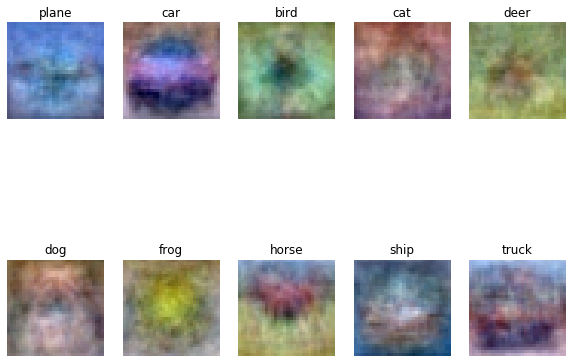

In [9]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])